In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import matrix_rank, inv
from pprint import pprint
import sys
import os
current_notebook_dir = os.getcwd()
# Replace with the path to your IT_PI.py function
project_root_dir = os.path.join(current_notebook_dir, '..', '..')
it_pi_module_dir = project_root_dir
sys.path.append(it_pi_module_dir)
import IT_PI
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering/', VIEW.as_view(), name=''),
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import ScalarFormatter



In [2]:
# Colebrook-White equation function to solve for friction factor f
def colebrook(Re, ks_D):
    # Initial guess for friction factor (Blasius correlation for smooth pipe)
    f = 0.079 / Re**0.25
    # Iterative solution for Colebrook-White equation
    for i in range(100):
        f_new = 1 / (-1 * np.log10((ks_D / 3.7) + (5.02 / (Re * np.sqrt(f)))))
        if abs(f_new - f) < 1e-6:  # Convergence criterion
            f = f_new
            break
        f = f_new
    Cf = f 
    return Cf

# Define the sample size
n_samples = 100000  # or any desired number
mu        = 0.001  # Example constant value in Pa.s
## IF REYNOLDS NUMBER AND RELATIVE ROUGHNESS ARE LOG UNIFORM DISTRIBUTED
log_Re                 = np.random.uniform(3, 5, n_samples)  
log_relative_roughness = np.random.uniform(-8, -0.7, n_samples)  
Re                     = 10**log_Re
relative_roughness     = 10**log_relative_roughness
rho = 200  # Example constant density (kg/m^3)
D   = np.random.uniform(1, 10, n_samples)
k   = relative_roughness * D  # Roughness height (m)
U   = (Re * mu) / (rho * D)  # Velocity (m/s)
Cf  = np.zeros(n_samples)
for i in range(n_samples):
    Cf[i] = colebrook(Re[i], relative_roughness[i])
print(f'Relative roughness range: {relative_roughness.min()} - {relative_roughness.max()}')
print(f'Reynolds number range: {Re.min()} - {Re.max()}')    

Relative roughness range: 1.000105880237177e-08 - 0.199526017459918
Reynolds number range: 1000.0459537415029 - 99998.17732666533


In [3]:
X              = np.column_stack((U, rho * np.ones(n_samples), D, k, mu * np.ones(n_samples)))
# Output matrix Y (Skin Friction Coefficient Cf)
Y              = Cf.reshape(-1, 1)
D_in           = np.matrix('1 -3 1 1 -1; -1 0 0 0 -1; 0 1 0 0 1')
num_input      = 2

In [4]:
print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_rows   = np.shape(D_in)[0]
num_cols   = np.shape(D_in)[1]
num_basis      = D_in.shape[1] -matrix_rank(D_in)
basis_matrices = IT_PI.calc_basis(D_in, num_basis)
print("Basis vectors:")
pprint(basis_matrices)

Rank of D_in: 3
D_in matrix:
 [[ 1 -3  1  1 -1]
 [-1  0  0  0 -1]
 [ 0  1  0  0  1]]
Basis vectors:
matrix([[ 0.,  0.,  1., -1.,  0.],
        [ 1.,  1.,  1.,  0., -1.]])


In [5]:
# Run dimensionless learning
results = IT_PI.main(
    X,
    Y.reshape(-1, 1),
    basis_matrices,
    num_input=num_input,
    estimator="binning",
    estimator_params={"num_bins": 50},
    seed=666
)



------------------------------------------------------------
num of parameters: 4

Using estimator: 'binning' with hyperparameters: {'num_bins': 50}

(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 4 (seed=666, Sun Jul 27 16:50:10 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 -2.818681643253186e+00 1.0e+00 5.44e-01  3e-01  5e-01 0:08.3
    2    600 -3.003371597556365e+00 2.1e+00 5.63e-01  2e-01  4e-01 0:16.8
    3    900 -3.082027914357504e+00 2.4e+00 5.33e-01  1e-01  3e-01 0:25.2
    4   1200 -3.010939131945654e+00 2.8e+00 5.29e-01  1e-01  3e-01 0:33.8
    5   1500 -3.034755302455637e+00 3.3e+00 5.24e-01  6e-02  2e-01 0:42.3
    6   1800 -3.067900588890281e+00 4.7e+00 5.72e-01  7e-02  2e-01 0:50.9
    7   2100 -3.059946761104094e+00 5.8e+00 5.21e-01  5e-02  2e-01 0:59.5
    8   2400 -3.073519502771202e+00 7.5e+00 5.50e-01  5e-02  2e-01 1:08.2
    9   2700 -3.034450562935620e+00 9.6e+00 6.09e-01  5e-02  2e-01 1:16.7
   11   3300 -3.07551

In [6]:
input_PI = results["input_PI"]
output_PI = results["output_PI"]
epsilon  = results["irreducible_error"]
uq       = results["uncertainty"]

coef_pi_list     = results["input_coef"]
variables = ['u', '\\rho', 'D', 'k','\\mu'];

optimal_pi_lab   = IT_PI.create_labels(np.array(coef_pi_list).reshape(-1, len(variables)), variables)
for j, label in enumerate(optimal_pi_lab):
    print(f'Optimal_pi_lab[{j}] = {label}')
    
input_PI[:, [0, 1]] = input_PI[:, [1, 0]]


Optimal_pi_lab[0] = $\frac{\mu^{1.0}}{u^{1.0} \cdot \rho^{1.0} \cdot D^{1.0}}$
Optimal_pi_lab[1] = $\frac{k^{0.99} \cdot \mu^{0.01}}{u^{0.01} \cdot \rho^{0.01} \cdot D^{1.0}}$


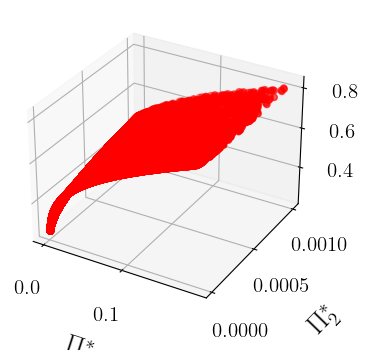

In [7]:
fig = plt.figure(figsize=(4, 4))
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['text.usetex'] = True  
ax = fig.add_subplot(111, projection='3d')
ax.scatter(input_PI[:, 0], input_PI[:, 1], output_PI, c='r', marker='o')
def prepare_label(label):
    if '$' in label:
        return r'{}'.format(label)
    return label
ax.set_xlabel(r'$\Pi_1^*$', fontsize=20, labelpad=20)  # Increase labelpad as needed
ax.set_ylabel(r'$\Pi_2^*$', fontsize=20, labelpad=25)
ax.set_zlabel(r'$C_f$', fontsize=15, labelpad=20)

ax.xaxis.set_tick_params(width=1, labelsize=15)
ax.yaxis.set_tick_params(width=1, labelsize=15)
ax.zaxis.set_tick_params(width=1, labelsize=15)
ax.tick_params(axis='both', which='major', labelsize=15, pad=10)
ax.grid(True)  
# plt.savefig('roughness_dimensionless.png', dpi=300, bbox_inches='tight')
# plt.savefig('roughness_dimensionless.eps', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [8]:
log_data         = np.log1p(input_PI)  # np.log1p is used to avoid log(0) issues
scaler          = StandardScaler()
scaled_log_data = scaler.fit_transform(log_data)
# Perform KMeans clustering on the scaled log-transformed data
regions                     = IT_PI.partition_space(scaled_log_data, n_clusters= 10)
results, ratio_X1, ratio_X2 = IT_PI.analyze_regions(input_PI[:,0], input_PI[:,1], Y, regions)

/opt/miniconda3/envs/IT_PI/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


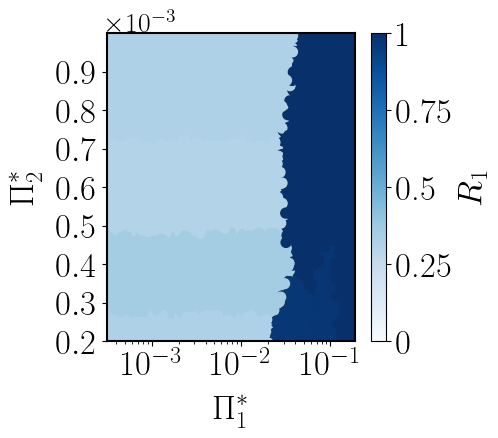

In [9]:
def plot_ratio_X1(X1, X2, ratio_X1):
    plt.figure(figsize=(4, 4))
    scatter = plt.scatter(X1, X2, c=ratio_X1, cmap='Blues', s=50, vmin=0, vmax=1) 
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)
    plt.xlabel(r" $\Pi_{1}^*$", fontsize=25, labelpad=10)  
    plt.ylabel(r" $\Pi_2^*$", fontsize=25, labelpad=10)
    plt.xscale('log')
    plt.xticks(fontsize=25)
    ax = plt.gca()
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, -3))
    ax.yaxis.set_major_formatter(formatter)
    plt.yticks(fontsize=25)
    ax.yaxis.get_offset_text().set_fontsize(20)
    offset_text = ax.yaxis.get_offset_text()
    x, y = offset_text.get_position()  # current position
    offset_text.set_position((x , y+1.5))  # shift it slightly left

    cbar = plt.colorbar(scatter)
    cbar.set_label('$R_1$', fontsize=25)
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])  # ✅ set tick locations
    cbar.set_ticklabels(['0', '0.25', '0.5', '0.75', '1'])  # ✅ set labels
    cbar.ax.tick_params(labelsize=25)  # ✅ set font size
    plt.xlim(10**(-3.5), np.max(X1))
    plt.ylim(0.0002, np.max(X2))
    #plt.savefig('roughness_region_1.png', dpi=300, bbox_inches='tight',transparent=True)
    #plt.savefig('roughness_region_1.eps',format='eps', dpi=200, bbox_inches='tight',transparent=True)
    plt.show()
    
plot_ratio_X1(input_PI[:,0], input_PI[:,1], ratio_X1)
